In [44]:
import pandas as pd
import numpy as np

In [45]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [46]:
df.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


In [29]:
df.columns

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'string_id', 'error_code', 'installation_type', 'efficiency'],
      dtype='object')

In [30]:
(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [31]:
print(df.shape)
print(test.shape)

(20000, 17)
(12000, 16)


In [32]:
df.isnull().sum()

id                       0
temperature           1001
irradiance             987
humidity                 0
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed               0
pressure                 0
string_id                0
error_code            5912
installation_type     5028
efficiency               0
dtype: int64

In [33]:
test.isna().sum()

id                       0
temperature            582
irradiance             615
humidity                 0
panel_age              607
maintenance_count      609
soiling_ratio          610
voltage                547
current                587
module_temperature     580
cloud_coverage         582
wind_speed               0
pressure                 0
string_id                0
error_code            3611
installation_type     2979
dtype: int64

In [34]:
test = test.drop(columns = ['error_code', 'installation_type', 'id'])

In [35]:
train = df.drop(columns = ['error_code', 'installation_type', 'id'])

In [36]:
## number of negative irradiance (sensor errors)
count = 0
for val in df['irradiance']:
    if val < 0:
        count += 1

count

424

In [37]:
for i in range(len(df)):
    if df['irradiance'][i] < 0:
        df['irradiance'][i] = 0

C:\Users\knaik\AppData\Local\Temp\ipykernel_13940\3546030277.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['irradiance'][i] = 0
C:\Users\knaik\AppData\Local\Temp\ipykernel_13940\3546030277.py:3: SettingWithCopyWarning: 
A value is t

In [38]:
df[df.select_dtypes(include='number').columns] = df.select_dtypes(include='number').fillna(df.median(numeric_only=True))

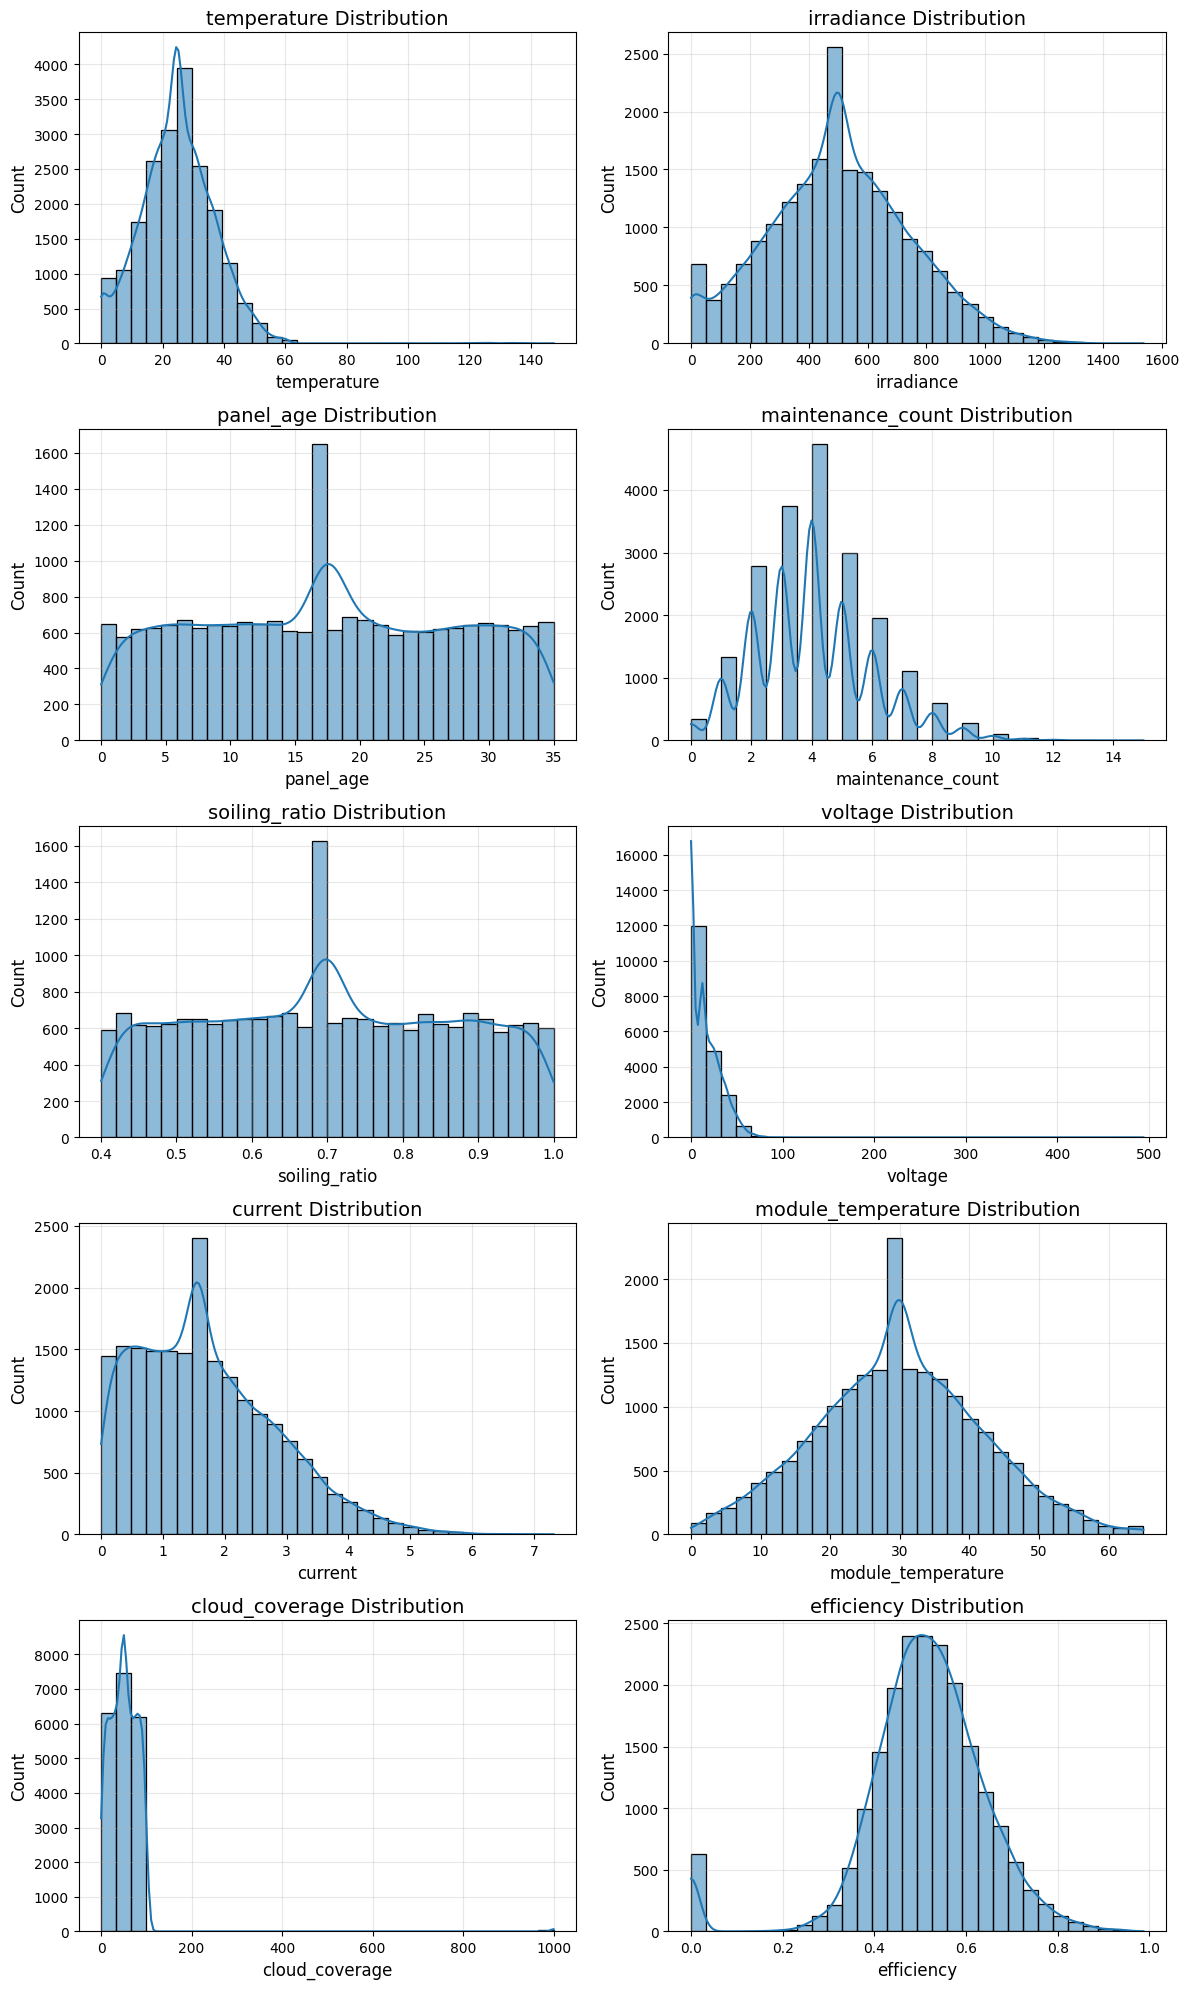

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get all float-type columns
float_columns = df.select_dtypes(include=['float64', 'float32']).columns

# Set number of subplots based on number of float columns
n_cols = 2  # You can change this based on how many plots you want per row
n_rows = (len(float_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each float column
for i, col in enumerate(float_columns):
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

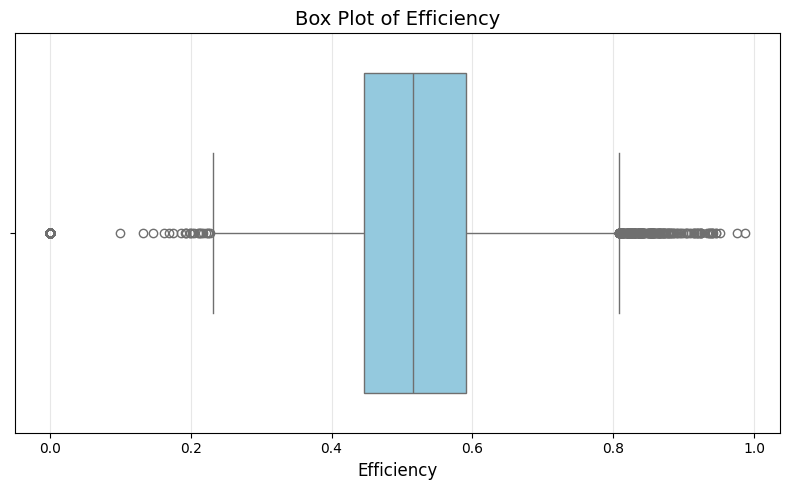

In [40]:
# Set the figure size
plt.figure(figsize=(8, 5))

# Create the box plot
sns.boxplot(x=train['efficiency'], color='skyblue')

# Customize the plot
plt.title('Box Plot of Efficiency', fontsize=14)
plt.xlabel('Efficiency', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
print(df['error_code'].value_counts())

error_code
E00    5977
E01    4100
E02    4011
Name: count, dtype: int64


In [42]:
print(df['installation_type'].value_counts())

installation_type
tracking     5067
fixed        4990
dual-axis    4915
Name: count, dtype: int64


In [43]:
df.describe()


,id,temperature,irradiance,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,efficiency
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,25.059378,503.241636,17.509150,4.011450,0.698818,16.049007,1.705825,29.920572,51.294016,0.510260
std,5773.647028,12.196201,239.665455,9.839019,1.950182,0.167838,17.459742,1.124935,11.825217,47.235208,0.140420
min,0.000000,0.000000,0.000000,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.000000
25%,4999.750000,17.311474,343.009829,9.238113,3.000000,0.558536,0.000000,0.813555,22.001083,26.548853,0.445613
50%,9999.500000,24.720345,499.654730,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,0.515709
75%,14999.250000,32.360468,658.315046,25.832048,5.000000,0.839569,25.819050,2.410531,37.596789,73.798123,0.590324
max,19999.000000,147.394168,1537.810349,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,0.987066
